<a href="https://colab.research.google.com/github/SandeepMLDLNPL/Machine_Learning_Models/blob/main/KMeans_Clustering_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

In [78]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Clustering").getOrCreate()

path = "/content/customer_segmentation.csv"

df = spark.read.option("header",'True').option('delimiter', ',').csv(path)
df.show(5)

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12-01-2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12-01-2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12-01-2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12-01-2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12-01-2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
only showing top 5 rows



In [79]:
df = df.selectExpr("*","Quantity*UnitPrice as Total_Bought")
df.show(3)


+---------+---------+--------------------+--------+---------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|      Total_Bought|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12-01-2010 8:26|     2.55|     17850|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|12-01-2010 8:26|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|12-01-2010 8:26|     2.75|     17850|United Kingdom|              22.0|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+------------------+
only showing top 3 rows



In [80]:
from pyspark.sql.functions import round,col
customer_df = df.select("CustomerID","Total_BOught").groupBy("CustomerID").sum("Total_Bought").withColumnRenamed('sum(Total_BOught)','sum_Total_BOught')
customer_df.show(5)

+----------+------------------+
|CustomerID|  sum_Total_BOught|
+----------+------------------+
|     16250|389.44000000000005|
|     15574| 702.2500000000001|
|     15555| 4758.199999999993|
|     15271|2485.8199999999997|
|     17714|             153.0|
+----------+------------------+
only showing top 5 rows



In [81]:
from pyspark.sql.functions import * 
joindf = df.join(customer_df,'CustomerID')


In [82]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans 
from pyspark.ml.feature import Normalizer 
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler 

In [83]:
stages = [StringIndexer(inputCol='StockCode',outputCol='Stock_code_indexed',handleInvalid='keep'),
          OneHotEncoder(inputCol='Stock_code_indexed',outputCol='stock_code_encoded'),
          StringIndexer(inputCol='Country',outputCol='country_indexed',handleInvalid='keep'),
          OneHotEncoder(inputCol='country_indexed',outputCol='country_encoded'),
          QuantileDiscretizer(numBuckets=3,inputCol='sum_Total_BOught',outputCol='Total_bought_index'),
          VectorAssembler(inputCols=['stock_code_encoded','country_encoded','Total_bought_index'],
                          outputCol='feature_raw'),
          Normalizer(inputCol='feature_raw',outputCol='feature',p=1.0),
          KMeans(featuresCol='feature').setK(3).setSeed(40)          
          ]
cluster_pipeline = Pipeline(stages=stages)
model = cluster_pipeline.fit(joindf)

In [86]:
df_with_clusters = model.transform(joindf).cache()
df_with_clusters

DataFrame[CustomerID: string, InvoiceNo: string, StockCode: string, Description: string, Quantity: string, InvoiceDate: string, UnitPrice: string, Country: string, Total_Bought: double, sum_Total_BOught: double, Stock_code_indexed: double, stock_code_encoded: vector, country_indexed: double, country_encoded: vector, Total_bought_index: double, feature_raw: vector, feature: vector, prediction: int]

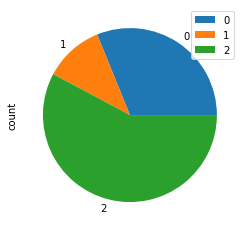

In [89]:
df_with_clusters.groupBy("prediction").count().toPandas().plot(kind='pie',x='prediction', y='count')

In [90]:
df_with_clusters.where(df_with_clusters.prediction==0).groupby('Country').count().show()

+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|235153|
+--------------+------+



In [91]:
df_with_clusters.where(df_with_clusters.prediction==1).groupby('Country').count().show()

+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|126725|
+--------------+------+



In [92]:
df_with_clusters.where(df_with_clusters.prediction==2).groupby('Country').count().show()

+------------------+-----+
|           Country|count|
+------------------+-----+
|            Sweden|  462|
|         Singapore|  229|
|           Germany| 9495|
|            France| 8491|
|            Greece|  146|
|European Community|   61|
|           Belgium| 2069|
|           Finland|  695|
|             Malta|  127|
|       Unspecified|  244|
|             Italy|  803|
|              EIRE| 7485|
|         Lithuania|   35|
|            Norway| 1086|
|             Spain| 2533|
|           Denmark|  389|
|           Iceland|  182|
|            Israel|  250|
|   Channel Islands|  758|
|               USA|  291|
+------------------+-----+
only showing top 20 rows

